In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,  LogisticRegression, Lasso, RidgeCV, BayesianRidge
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import GroupKFold

plt.style.use("fivethirtyeight")
mypal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.chdir('E:\iCloudDrive\Desktop\Probability Machine Learning\Project')
data_path = "march-machine-learning-mania-2024/"

In [4]:
# Function to load information
def loading(file_name, league):
    file_path = data_path + file_name
    return pd.read_csv(file_path).assign(League=league)

# Load and merge Men's and Women's NCAA tournament seeds
tournament_seeds = pd.concat([
    loading("MNCAATourneySeeds.csv", 'M'),
    loading("WNCAATourneySeeds.csv", 'W'),
]).reset_index(drop=True)

# Load and merge Men's and Women's NCAA season detailed results
season_detailed_results = pd.concat([
    loading("MRegularSeasonDetailedResults.csv", 'M'),
    loading("WRegularSeasonDetailedResults.csv", 'W'),
]).reset_index(drop=True)

# Load and merge Men's and Women's NCAA tournament compact results
tournament_compact_results = pd.concat([
    loading("MNCAATourneyCompactResults.csv", 'M'),
    loading("WNCAATourneyCompactResults.csv", 'W'),
]).reset_index(drop=True)


In [5]:
# Define a function to prepare season results data with new column names
def prepare_season_results(df, team_prefix, result_flag):
    columns_map = {
        f"{team_prefix}TeamID": "TeamID", 
        f"{team_prefix}Score": "TeamScore",
        "LScore" if team_prefix == "W" else "WScore": "OppScore",
        f"{team_prefix}FGM": "FieldGoalsMade", 
        f"{team_prefix}FGA": "FieldGoalsAtp",
        f"{team_prefix}FGM3": "ThreePointersMade", 
        f"{team_prefix}FGA3": "ThreePointersAtp",
        f"{team_prefix}FTM": "FreeThrowsMade", 
        f"{team_prefix}FTA": "FreeThrowsAtp",
        f"{team_prefix}OR": "OffensiveRebound", 
        f"{team_prefix}DR": "DefensiveRebound",
        f"{team_prefix}Ast": "Assists", 
        f"{team_prefix}TO": "Turnovers", 
        f"{team_prefix}Stl": "Steals",
        f"{team_prefix}Blk": "Blocks", 
        f"{team_prefix}PF": "PersonalFouls"
    }
    return (
        df[[col for col in columns_map.keys() if col in df.columns] + ["Season", "League", "DayNum"]]
        .assign(GameResult=result_flag)
        .rename(columns=columns_map)
    )

# Load and process season results for both winning and losing teams
df_team_season_results = pd.concat([
    prepare_season_results(season_detailed_results, "W", "W"),
    prepare_season_results(season_detailed_results, "L", "L"),
]).reset_index(drop=True)

# Calculate additional metrics based on the processed data
df_team_season_results["ScoreDiff"] = df_team_season_results["TeamScore"] - df_team_season_results["OppScore"]
df_team_season_results["Win"] = (df_team_season_results["GameResult"] == "W").astype(int)
df_team_season_results["ThreePointerHitRate"] = df_team_season_results["ThreePointersMade"] / df_team_season_results["ThreePointersAtp"]
df_team_season_results["FieldGoalsPercentage"] = df_team_season_results["FieldGoalsMade"] / df_team_season_results["FieldGoalsAtp"]
df_team_season_results["FreeThrowHitRate"] = df_team_season_results["FreeThrowsMade"] / df_team_season_results["FreeThrowsAtp"]


In [6]:
team_season_agg = (
    df_team_season_results.groupby(["Season", "TeamID", "League"])
    .agg(
        AvgScoreDiff=("ScoreDiff", "mean"),
        AvgThreePointerMade=("ThreePointersMade", "mean"),
        AvgThreePointerAtp=("ThreePointersAtp", "mean"),
        AvgFreeThrowsMade= ("FreeThrowsMade", "mean"),
        AvgFreeThrowsAtp=("FreeThrowsAtp", "mean"),
        AvgFieldGoalsMade=("FieldGoalsMade", "mean"),
        AvgFieldGoalsAtp=("FieldGoalsAtp", "mean"),
        AvgThreePointerHitRate=("ThreePointerHitRate", "mean"),
        AvgFieldGoalsPercentage=("FieldGoalsPercentage", "mean"),
        AvgFreeThrowHitRate=("FreeThrowHitRate", "mean"),
        MedianScoreDiff=("ScoreDiff", "median"),
        MinScoreDiff=("ScoreDiff", "min"),
        MaxScoreDiff=("ScoreDiff", "max"),
        Wins=("Win", "sum"),
        Losses=("GameResult", lambda x: (x == "L").sum()),
        WinPercentage=("Win", "mean"),
    )
    .reset_index()
)

In [7]:
# Aggregating team season results with detailed statistical metrics
team_season_agg = (
    df_team_season_results.groupby(["Season", "TeamID", "League"])
    .agg(
        AvgScoreDiff=pd.NamedAgg(column="ScoreDiff", aggfunc="mean"),
        AvgThreePointerMade=pd.NamedAgg(column="ThreePointersMade", aggfunc="mean"),
        AvgThreePointerAtp=pd.NamedAgg(column="ThreePointersAtp", aggfunc="mean"),
        AvgFreeThrowsMade=pd.NamedAgg(column="FreeThrowsMade", aggfunc="mean"),
        AvgFreeThrowsAtp=pd.NamedAgg(column="FreeThrowsAtp", aggfunc="mean"),
        AvgFieldGoalsMade=pd.NamedAgg(column="FieldGoalsMade", aggfunc="mean"),
        AvgFieldGoalsAtp=pd.NamedAgg(column="FieldGoalsAtp", aggfunc="mean"),
        AvgThreePointerHitRate=pd.NamedAgg(column="ThreePointerHitRate", aggfunc="mean"),
        AvgFieldGoalsPercentage=pd.NamedAgg(column="FieldGoalsPercentage", aggfunc="mean"),
        AvgFreeThrowHitRate=pd.NamedAgg(column="FreeThrowHitRate", aggfunc="mean"),
        MedianScoreDiff=pd.NamedAgg(column="ScoreDiff", aggfunc="median"),
        MinScoreDiff=pd.NamedAgg(column="ScoreDiff", aggfunc="min"),
        MaxScoreDiff=pd.NamedAgg(column="ScoreDiff", aggfunc="max"),
        Wins=pd.NamedAgg(column="Win", aggfunc="sum"),
        Losses=pd.NamedAgg(column="GameResult", aggfunc=lambda x: (x == "L").sum()),
        WinPercentage=pd.NamedAgg(column="Win", aggfunc="mean")
    )
    .reset_index()
)


In [8]:
# Normalize the 'Seed' column to a numeric 'SeedNum'
tournament_seeds["SeedNum"] = (
    tournament_seeds["Seed"].str.replace("[ab]", "", regex=True)  # Remove 'a' and 'b' using regex for efficiency
    .str[1:]  # Strip the leading character
    .astype(int)  # Convert the remaining string to an integer
)

# Merge the aggregated season data with the seeds data
team_season_agg = team_season_agg.merge(
    tournament_seeds[['Season', 'TeamID', 'League', 'SeedNum']],  # Select only necessary columns before merging
    on=["Season", "TeamID", "League"],
    how="left"
)


In [9]:
# Function to prepare tournament results data
def prepare_tourney_results(df, win_col_prefix, lose_col_prefix, result_flag):
    column_mapping = {
        f"{win_col_prefix}TeamID": "TeamID",
        f"{lose_col_prefix}TeamID": "OppTeamID",
        f"{win_col_prefix}Score": "TeamScore",
        f"{lose_col_prefix}Score": "OppScore"
    }
    return (
        df[["Season", "League", f"{win_col_prefix}TeamID", f"{lose_col_prefix}TeamID",
            f"{win_col_prefix}Score", f"{lose_col_prefix}Score"]]
        .assign(GameResult=result_flag)
        .rename(columns=column_mapping)
    )

# Combine tournament results for winning and losing teams
df_team_tourney_results = pd.concat([
    prepare_tourney_results(tournament_compact_results, "W", "L", "W"), #rev
    prepare_tourney_results(tournament_compact_results, "L", "W", "L") #rev
]).reset_index(drop=True)

# Add a 'Win' column indicating whether the team won the game
df_team_tourney_results["Win"] = (df_team_tourney_results["GameResult"] == "W").astype(int)

In [10]:
df_historic_tourney_features = None
# Initial merge of team data
df_historic_tourney_features = df_team_tourney_results.merge(
    team_season_agg[
        ["Season", "League", "TeamID", "AvgScoreDiff", "AvgThreePointerMade",
         "AvgThreePointerAtp", "AvgFreeThrowsMade", "AvgFreeThrowsAtp",
         "AvgFieldGoalsMade", "AvgFieldGoalsAtp", "AvgThreePointerHitRate",
         "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate", "MedianScoreDiff",
         "MinScoreDiff", "WinPercentage", "MaxScoreDiff", "SeedNum"]
    ],
    on=["Season", "League", "TeamID"],
    how="left",
)

# Secondary merge with opponent data
df_historic_tourney_features = df_historic_tourney_features.merge(
    team_season_agg[
        ["Season", "League", "TeamID", "AvgScoreDiff", "AvgThreePointerMade",
         "AvgThreePointerAtp", "AvgFreeThrowsMade", "AvgFreeThrowsAtp",
         "AvgFieldGoalsMade", "AvgFieldGoalsAtp", "AvgThreePointerHitRate",
         "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate", "MedianScoreDiff",
         "MinScoreDiff", "WinPercentage", "MaxScoreDiff", "SeedNum"]
    ].rename(
        columns={
            "TeamID": "OppTeamID",
            "WinPercentage": "OppWinPercentage",
            "MedianScoreDiff": "OppMedianScoreDiff",
            "SeedNum": "OppSeedNum",
            "AvgScoreDiff": "OppAvgScoreDiff",
            "AvgThreePointerMade": "OppAvgThreePointerMade",
            "AvgThreePointerAtp": "OppAvgThreePointerAtp",
            "AvgFreeThrowsMade": "OppAvgFreeThrowsMade",
            "AvgFreeThrowsAtp": "OppAvgFreeThrowsAtp",
            "AvgFieldGoalsMade": "OppAvgFieldGoalsMade",
            "AvgFieldGoalsAtp": "OppAvgFieldGoalsAtp",
            "AvgThreePointerHitRate": "OppAvgThreePointerHitRate",
            "AvgFieldGoalsPercentage": "OppAvgFieldGoalsPercentage",
            "AvgFreeThrowHitRate": "OppAvgFreeThrowHitRate",
            "MinScoreDiff": "OppMinScoreDiff",
            "MaxScoreDiff": "OppMaxScoreDiff",
        }
    ),
    on=["Season", "League", "OppTeamID"],
)

In [11]:
# List of metric pairs to calculate differences
metric_pairs = [
    ("WinPercentage", "OppWinPercentage", "WinPctDiff"),
    ("SeedNum", "OppSeedNum", "SeedNumDiff"),
    ("AvgScoreDiff", "OppAvgScoreDiff", "AvgScoreDiffDiff"),
    ("MedianScoreDiff", "OppMedianScoreDiff", "MedianScoreDiffDiff"),
    ("AvgThreePointerMade", "OppAvgThreePointerMade", "AvgThreePointerMadeDiff"),
    ("AvgThreePointerAtp", "OppAvgThreePointerAtp", "AvgThreePointerAtpDiff"),
    ("AvgFreeThrowsMade", "OppAvgFreeThrowsMade", "AvgFreeThrowsMadeDiff"),
    ("AvgFreeThrowsAtp", "OppAvgFreeThrowsAtp", "AvgFreeThrowsAtpDiff"),
    ("AvgFieldGoalsMade", "OppAvgFieldGoalsMade", "AvgFieldGoalsMadeDiff"),
    ("AvgFieldGoalsAtp", "OppAvgFieldGoalsAtp", "AvgFieldGoalsAtpDiff"),
    ("AvgThreePointerHitRate", "OppAvgThreePointerHitRate", "AvgThreePointerHitRateDiff"),
    ("AvgFieldGoalsPercentage", "OppAvgFieldGoalsPercentage", "AvgFieldGoalsPercentageDiff"),
    ("AvgFreeThrowHitRate", "OppAvgFreeThrowHitRate", "AvgFreeThrowHitRateDiff"),
    ("MinScoreDiff", "OppMinScoreDiff", "MinScoreDiffDiff"),
    ("MaxScoreDiff", "OppMaxScoreDiff", "MaxScoreDiffDiff")
]

# Calculate the differences for each metric pair
for metric, opp_metric, diff_metric in metric_pairs:
    df_historic_tourney_features[diff_metric] = (
        df_historic_tourney_features[metric] - df_historic_tourney_features[opp_metric]
    )


# Baseline - Higher Seed Wins

In [12]:
df_historic_tourney_features["BaselinePred"] = (
    df_historic_tourney_features["SeedNum"]
    < df_historic_tourney_features["OppSeedNum"]
)

df_historic_tourney_features.loc[
    df_historic_tourney_features["SeedNum"]
    == df_historic_tourney_features["OppSeedNum"],
    "BaselinePred",
] = (
    df_historic_tourney_features["WinPercentage"]
    > df_historic_tourney_features["OppWinPercentage"]
)

cv_scores_baseline = []
for season in df_historic_tourney_features["Season"].unique():
    pred = df_historic_tourney_features.query("Season == @season")[
        "BaselinePred"
    ].astype("int")
    y = df_historic_tourney_features.query("Season == @season")["Win"]
    score = accuracy_score(y, pred)
    score_ll = log_loss(y, pred)
    cv_scores_baseline.append(score)
    print(f"Holdout season {season} - Accuracy {score:0.4f} Log Loss {score_ll:0.4f}")

print(f"Baseline accuracy {np.mean(cv_scores_baseline):0.4f}")

Holdout season 2003 - Accuracy 0.6562 Log Loss 12.3900
Holdout season 2004 - Accuracy 0.7344 Log Loss 9.5741
Holdout season 2005 - Accuracy 0.6719 Log Loss 11.8268
Holdout season 2006 - Accuracy 0.6719 Log Loss 11.8268
Holdout season 2007 - Accuracy 0.7969 Log Loss 7.3214
Holdout season 2008 - Accuracy 0.7656 Log Loss 8.4477
Holdout season 2009 - Accuracy 0.7344 Log Loss 9.5741
Holdout season 2010 - Accuracy 0.7402 Log Loss 9.3657
Holdout season 2011 - Accuracy 0.7000 Log Loss 10.8131
Holdout season 2012 - Accuracy 0.7923 Log Loss 7.4860
Holdout season 2013 - Accuracy 0.7154 Log Loss 10.2586
Holdout season 2014 - Accuracy 0.7000 Log Loss 10.8131
Holdout season 2015 - Accuracy 0.7923 Log Loss 7.4860
Holdout season 2016 - Accuracy 0.6846 Log Loss 11.3676
Holdout season 2017 - Accuracy 0.7769 Log Loss 8.0405
Holdout season 2018 - Accuracy 0.7000 Log Loss 10.8131
Holdout season 2019 - Accuracy 0.7538 Log Loss 8.8723
Holdout season 2021 - Accuracy 0.7519 Log Loss 8.9411
Holdout season 2022 

# Predictive Models

In [13]:
features = [
    "WinPctDiff",
    "SeedNumDiff",
    "AvgScoreDiffDiff",
    "AvgThreePointerHitRateDiff",
    "AvgFieldGoalsPercentageDiff",
    "AvgFreeThrowHitRateDiff",
    #   "WinPercentage",
    #    "MedianScoreDiff",
    #   "SeedNum",
    #   "OppWinPercentage",
    #   "OppMedianScoreDiff",
    #   "OppSeedNum",
    #   "AvgThreePointerMadeDiff",
    #   "AvgThreePointerAtpDiff",
    #   "AvgFreeThrowsMadeDiff",
    #   "AvgFreeThrowsAtpDiff",
    #   "AvgFieldGoalsMadeDiff",
    #   "AvgFieldGoalsAtpDiff",
]
target = "Win"

X = df_historic_tourney_features[features]
y = df_historic_tourney_features[target]
groups = df_historic_tourney_features["Season"]
seasons = df_historic_tourney_features["Season"].unique()

# Setup cross-validation
gkf = GroupKFold(n_splits=df_historic_tourney_features["Season"].nunique())

cv_results = []
models = [
    LinearRegression(),
    Lasso(alpha=0.1),
    RidgeCV(alphas=(0.1, 1.0, 10.0)),
    LogisticRegression(),
    svm.LinearSVC(loss='hinge', penalty='l2', dual='auto', max_iter=int(1E9)),
    svm.SVC(kernel='poly'),
    svm.SVC(kernel='rbf'),
    xgb.XGBRegressor(eval_metric="logloss", n_estimators=1000, learning_rate=0.001,),
    RandomForestRegressor(n_estimators=1000),
    ]


model_idx = 1
for model in models:

    season_idx = 0
    for train_index, test_index in gkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Prepare the model
        holdout_season = seasons[season_idx]
        #print(f"Holdout Season: {holdout_season}")
        # Train the model
        m = model.fit(X_train, y_train);

        # Predict on the test set
        y_pred = model.predict(X_test)

        y_pred = y_pred > 0.5
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        cv_results.append(accuracy)
        season_idx += 1
        #print(f"Season {holdout_season}: {accuracy} {score_ll}")
            
    # Print the average accuracy across all folds
    print(f"Model: {model_idx} Average CV Accuracy: {np.mean(cv_results)}")
    model_idx += 1

Model: 1 Average CV Accuracy: 0.731703831028152
Model: 2 Average CV Accuracy: 0.7345365364156672
Model: 3 Average CV Accuracy: 0.7349991053565497
Model: 4 Average CV Accuracy: 0.7352133396817756
Model: 5 Average CV Accuracy: 0.7353430824200803


KeyboardInterrupt: 

# Bayesian Inference

In [21]:
import pymc as pm
import arviz as az

# Ignore all message
import logging
logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

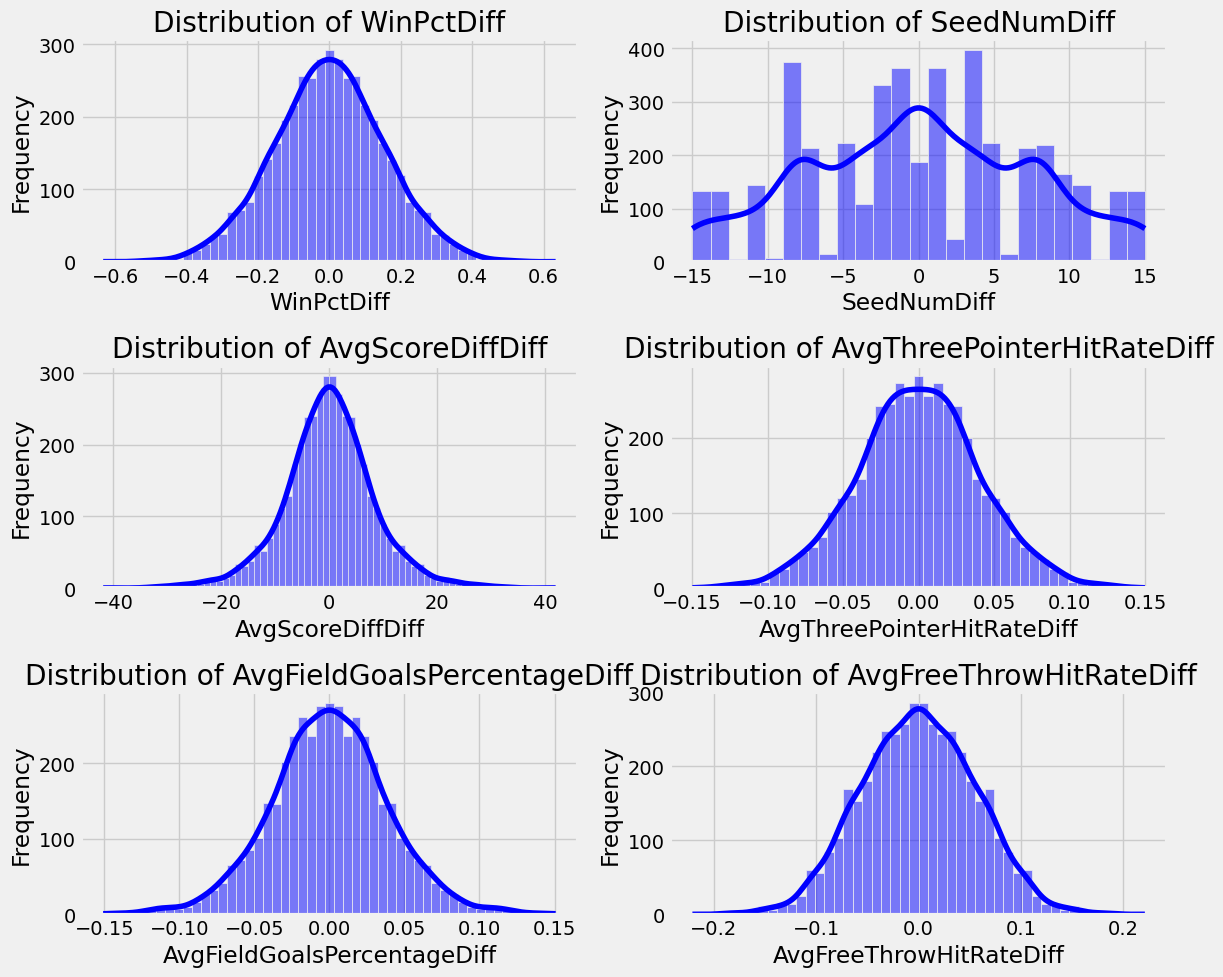

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of predictors
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)  # Adjust the grid size accordingly if you have more or fewer predictors
    sns.histplot(df_historic_tourney_features[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [32]:
cv_results=[]
# CV for Bayesian Inference
season_idx = 0
for train_index, test_index in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    holdout_season = seasons[season_idx]
    with pm.Model() as logistic_model:
  
        # Set Normal priors for the coefficients
        intercept = pm.Normal('intercept', mu=0, sigma=1)
        betas = pm.Normal('betas', mu=0, sigma=np.array(np.round(X_train.std(),2)), shape=X_train.shape[1])

        # set predictors as shared variable
        predictors = pm.MutableData("predictors", X_train.values)

        # Likelihood (sampling distribution) of observations
        likelihood = pm.Deterministic("likelihood", pm.invlogit(intercept + pm.math.dot(predictors, betas)))                     

        # Bernoulli random vector with probability of success
        outcome  = pm.Bernoulli('outcome', p=likelihood, observed=y_train)
        
        sampler = pm.NUTS() # Use the no-uturn sampler
        #sampler = pm.Slice() # Use the slice sampling algorithm

        # Sample from the posterior
        trace = pm.sample(draws=5000, step = sampler, chains=4, tune=1000, random_seed=100)

    with logistic_model:

        # update values of predictors:
        pm.set_data({"predictors": X_test.values})

        # use the updated values and predict outcomes and probabilities:
        trace = pm.sample_posterior_predictive(
            trace,
            var_names=["likelihood"],
            return_inferencedata=True,
            predictions=True,
            extend_inferencedata=True
        )

    y_pred = trace.predictions["likelihood"].mean(("chain", "draw")).values
    y_pred = y_pred > 0.5
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Season {holdout_season}: {accuracy}")
    cv_results.append(accuracy)
    season_idx += 1

# Print the average accuracy across all folds
print(f"Bayesian Model: Average CV Accuracy: {np.mean(cv_results)}")

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

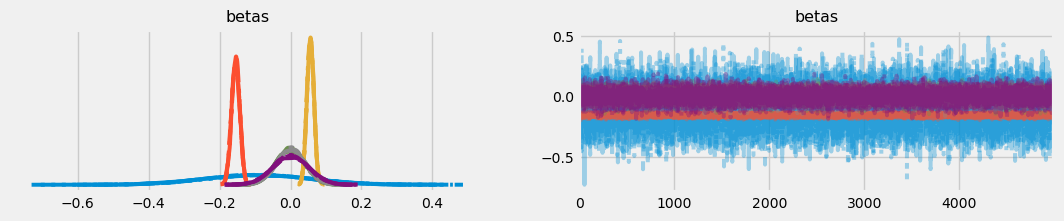

In [35]:
az.plot_trace(trace, var_names=["betas"]);

In [36]:
az.summary(trace, var_names=["betas"], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-0.0908,0.1466,-0.3662,0.1836,0.0010,0.0009,23005.0870,16606.6097,1.0000
betas[1],-0.1547,0.0114,-0.1767,-0.1339,0.0001,0.0001,22013.3313,16883.1552,1.0002
betas[2],0.0560,0.0098,0.0378,0.0745,0.0001,0.0000,19845.2955,17054.0050,1.0000
betas[3],-0.0005,0.0399,-0.0749,0.0744,0.0003,0.0003,23068.2741,14901.9578,1.0003
betas[4],0.0006,0.0403,-0.0745,0.0771,0.0002,0.0003,27919.6217,15217.1259,1.0003
betas[5],0.0007,0.0499,-0.0931,0.0935,0.0003,0.0003,24772.1756,16606.4995,1.0003


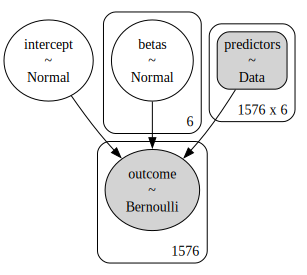

In [39]:
pm.model_to_graphviz(logistic_model)

# Prediction with 2024 games

In [45]:
# 2024 real tourney game
tourney_2024 = pd.concat(
    [
        pd.read_csv(data_path + "Men2024.csv").assign(League="M"),
        pd.read_csv(data_path + "Women2024.csv").assign(League="W"),
    ],
).reset_index(drop=True)

In [46]:
tourney_2024.head()

,TeamID,TeamIDOpp,Win,League
0,1163,1391,0,M
1,1194,1321,0,M
2,1361,1412,0,M
3,1120,1463,1,M
4,1140,1182,0,M


In [47]:
test_season = 2024

seeds_2024 = pd.read_csv(data_path + "2024_tourney_seeds.csv")

seeds_2024["SeedNum"] = (
    seeds_2024["Seed"].str.replace("a", "").str.replace("b", "").str[1:].astype("int")
)

tourney_pairs = (
    seeds_2024.merge(seeds_2024, on=["Tournament"], suffixes=("", "Opp"))
    .assign(Season=test_season)
    .query("TeamID != TeamIDOpp")
    .rename(columns={"Tournament": "League"})
)

tourney_pairs = (
    tourney_pairs.merge(
        team_season_agg[
            ["Season", "League", "TeamID", "AvgScoreDiff", "AvgThreePointerMade",
         "AvgThreePointerAtp", "AvgFreeThrowsMade", "AvgFreeThrowsAtp",
         "AvgFieldGoalsMade", "AvgFieldGoalsAtp", "AvgThreePointerHitRate",
         "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate", "MedianScoreDiff",
         "MinScoreDiff", "WinPercentage", "MaxScoreDiff"]
        ],
        on=["Season", "League", "TeamID"],
        how="left",
    )
    .merge(
        team_season_agg[
            ["Season", "League", "TeamID", "AvgScoreDiff", "AvgThreePointerMade",
         "AvgThreePointerAtp", "AvgFreeThrowsMade", "AvgFreeThrowsAtp",
         "AvgFieldGoalsMade", "AvgFieldGoalsAtp", "AvgThreePointerHitRate",
         "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate", "MedianScoreDiff",
         "MinScoreDiff", "WinPercentage", "MaxScoreDiff"]
        ].rename(
            columns={
            "TeamID": "TeamIDOpp",
            "WinPercentage": "OppWinPercentage",
            "MedianScoreDiff": "OppMedianScoreDiff",
            "SeedNum": "OppSeedNum",
            "AvgScoreDiff": "OppAvgScoreDiff",
            "AvgThreePointerMade": "OppAvgThreePointerMade",
            "AvgThreePointerAtp": "OppAvgThreePointerAtp",
            "AvgFreeThrowsMade": "OppAvgFreeThrowsMade",
            "AvgFreeThrowsAtp": "OppAvgFreeThrowsAtp",
            "AvgFieldGoalsMade": "OppAvgFieldGoalsMade",
            "AvgFieldGoalsAtp": "OppAvgFieldGoalsAtp",
            "AvgThreePointerHitRate": "OppAvgThreePointerHitRate",
            "AvgFieldGoalsPercentage": "OppAvgFieldGoalsPercentage",
            "AvgFreeThrowHitRate": "OppAvgFreeThrowHitRate",
            "MinScoreDiff": "OppMinScoreDiff",
            "MaxScoreDiff": "OppMaxScoreDiff",
            }
        ),
        on=["Season", "League", "TeamIDOpp"],
    )
    .reset_index(drop=True)
)

In [48]:
# Add test features we need to use
tourney_pairs["BaselinePred"] = (
    tourney_pairs["SeedNum"] < tourney_pairs["SeedNumOpp"]
)

tourney_pairs.loc[
    tourney_pairs["SeedNum"] == tourney_pairs["SeedNumOpp"],
    "BaselinePred",
] = (
    tourney_pairs["WinPercentage"] > tourney_pairs["OppWinPercentage"]
)

tourney_pairs["WinPctDiff"] = (
    tourney_pairs["WinPercentage"] - tourney_pairs["OppWinPercentage"]
)

tourney_pairs["SeedNumDiff"] = (
    tourney_pairs["SeedNum"] - tourney_pairs["SeedNumOpp"]
)

tourney_pairs["AvgScoreDiffDiff"] = (
    tourney_pairs["AvgScoreDiff"] - tourney_pairs["OppAvgScoreDiff"]
)

tourney_pairs["AvgThreePointerHitRateDiff"] = (
    tourney_pairs["AvgThreePointerHitRate"] - tourney_pairs["OppAvgThreePointerHitRate"]
)

tourney_pairs["AvgFieldGoalsPercentageDiff"] = (
    tourney_pairs["AvgFieldGoalsPercentage"] - tourney_pairs["OppAvgFieldGoalsPercentage"]
)

tourney_pairs["AvgFreeThrowHitRateDiff"] = (
    tourney_pairs["AvgFreeThrowHitRate"] - tourney_pairs["OppAvgFreeThrowHitRate"]
)

In [49]:
# All combinations of games with feartures
tourney_pairs.head()

,League,Seed,TeamID,SeedNum,SeedOpp,TeamIDOpp,SeedNumOpp,Season,AvgScoreDiff,AvgThreePointerMade,...,OppMinScoreDiff,OppWinPercentage,OppMaxScoreDiff,BaselinePred,WinPctDiff,SeedNumDiff,AvgScoreDiffDiff,AvgThreePointerHitRateDiff,AvgFieldGoalsPercentageDiff,AvgFreeThrowHitRateDiff
0,M,W01,1163,1,W02,1235,2,2024,17.058824,8.794118,...,-15,0.794118,55,True,0.117647,-1,2.794118,0.020953,0.032912,0.048511
1,M,W01,1163,1,W03,1228,3,2024,17.058824,8.794118,...,-9,0.764706,33,True,0.147059,-2,6.441176,0.011540,0.024075,0.010630
2,M,W01,1163,1,W04,1120,4,2024,17.058824,8.794118,...,-16,0.794118,40,True,0.117647,-3,1.764706,0.012925,0.021727,-0.001111
3,M,W01,1163,1,W05,1361,5,2024,17.058824,8.794118,...,-18,0.687500,32,True,0.224265,-4,10.215074,0.050597,0.056380,0.015622
4,M,W01,1163,1,W06,1140,6,2024,17.058824,8.794118,...,-16,0.696970,57,True,0.214795,-5,5.119430,0.015183,0.033849,0.030599


In [50]:
# Merge two table
tourney_2024 = (
    tourney_2024.merge(
        tourney_pairs,
        on=["TeamID", "TeamIDOpp", "League"],
        how="left",
    )
)

tourney_2024.head()

,TeamID,TeamIDOpp,Win,League,Seed,SeedNum,SeedOpp,SeedNumOpp,Season,AvgScoreDiff,...,OppMinScoreDiff,OppWinPercentage,OppMaxScoreDiff,BaselinePred,WinPctDiff,SeedNumDiff,AvgScoreDiffDiff,AvgThreePointerHitRateDiff,AvgFieldGoalsPercentageDiff,AvgFreeThrowHitRateDiff
0,1163,1391,0,M,W01,1.0,W16,16.0,2024.0,17.058824,...,-31.0,0.612903,21.0,True,0.298861,-15.0,17.703985,-0.000205,0.037091,-0.003491
1,1194,1321,0,M,W08,8.0,W09,9.0,2024.0,9.272727,...,-30.0,0.656250,32.0,True,0.101326,-1.0,4.585227,-0.048905,0.023238,-0.021849
2,1361,1412,0,M,W05,5.0,W12,12.0,2024.0,6.843750,...,-23.0,0.666667,28.0,True,0.020833,-7.0,5.267992,-0.015577,-0.011408,-0.006092
3,1120,1463,1,M,W04,4.0,W13,13.0,2024.0,15.294118,...,-15.0,0.689655,25.0,True,0.104462,-9.0,9.880325,0.004155,0.012698,0.045634
4,1140,1182,0,M,W06,6.0,W11,11.0,2024.0,11.939394,...,-19.0,0.676471,22.0,True,0.020499,-5.0,8.468806,0.015151,0.029345,-0.006771


In [51]:
# Train with all previou data
with pm.Model() as logistic_model:
  
    # Set Normal priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    betas = pm.Normal('betas', mu=0, sigma=np.array(np.round(X.std(),2)), shape=X.shape[1])

    # set predictors as shared variable
    predictors = pm.MutableData("predictors", X.values)

    # Likelihood (sampling distribution) of observations
    likelihood = pm.Deterministic("likelihood", pm.invlogit(intercept + pm.math.dot(predictors, betas)))                     

    # Bernoulli random vector with probability of success
    outcome  = pm.Bernoulli('outcome', p=likelihood, observed=y)

    sampler = pm.NUTS() # Use the no-uturn sampler
    #sampler = pm.Slice() # Use the slice sampling algorithm

    # Sample from the posterior
    trace = pm.sample(draws=5000, step = sampler, chains=4, tune=1000, random_seed=100)

Output()

In [52]:
# Predict with real 2024 tourney
X_test_2024 = tourney_2024[features]
y_test_2024 = tourney_2024[target]

with logistic_model:
    # update values of predictors:
    pm.set_data({"predictors": X_test_2024.values})

    # use the updated values and predict outcomes and probabilities:
    trace = pm.sample_posterior_predictive(
        trace,
        var_names=["likelihood"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True
    )

y_pred_2024 = trace.predictions["likelihood"].mean(("chain", "draw")).values
y_pred_2024 = y_pred_2024 > 0.5
accuracy = accuracy_score(y_test_2024, y_pred_2024)

# Print the average accuracy across all folds
print(f"Bayesian Model: Accuracy: {accuracy}")

Output()

Bayesian Model: Accuracy: 0.6666666666666666
